# Exploratory Notebook Phase 3 Project

In [668]:
import pandas as pd
import numpy as np
import math as math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import loguniform

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import plot_roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,accuracy_score, precision_score, f1_score
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [142]:
X = pd.read_csv('data/training_set_features.csv')
y = pd.read_csv('data/training_set_labels.csv')

## Investigate Features

In [143]:
X.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,...,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,...,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,...,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,...,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,...,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,...,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


In [144]:
X.describe(include=object)

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
count,26707,25300,26707,26707,22284,25299,24665,25244,26707,26707,13377,13237
unique,5,4,4,2,3,2,2,3,10,3,21,23
top,65+ Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,lzgpxyit,"MSA, Not Principle City",fcxhlnwr,xtkaffoo
freq,6843,10097,21222,15858,12777,13555,18736,13560,4297,11645,2468,1778


It looks like most of these can be encoded using `OneHotEncoder` but a few may need orginal encoding

In [145]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

## Investigate Targets

In [146]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   respondent_id     26707 non-null  int64
 1   h1n1_vaccine      26707 non-null  int64
 2   seasonal_vaccine  26707 non-null  int64
dtypes: int64(3)
memory usage: 626.1 KB


Check to see if the two dataframes are equal in length

In [147]:
assert len(X) == len(y)

In [148]:
h1n1_counts = y['h1n1_vaccine'].value_counts(normalize=True).reset_index()
seasonal_counts = y['seasonal_vaccine'].value_counts(normalize=True).reset_index()

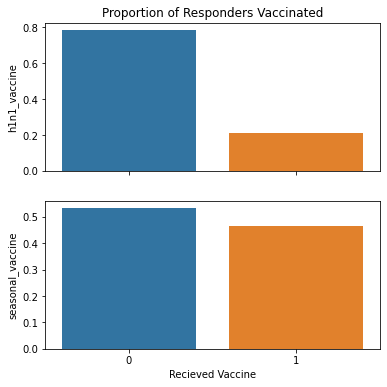

In [149]:
fig, ax = plt.subplots(2, 1, figsize=(6,6), sharex=True)

sns.barplot(data=h1n1_counts, x='index', y='h1n1_vaccine', ax=ax[0])
ax[0].set_title('Proportion of Responders Vaccinated')
ax[0].set_xlabel ('')
sns.barplot(data=seasonal_counts, x='index', y='seasonal_vaccine', ax=ax[1])
ax[1].set_xlabel('Recieved Vaccine')
plt.show()

It looks like the seasonal vaccine is balanced but the h1n1 has a class imbalance that we'll have to handle

In [150]:
X_tt, X_val, y_tt, y_val = train_test_split(X, y['h1n1_vaccine'], random_state=42)

In [151]:
# Split out the test set
X_train, X_test, y_train, y_test = train_test_split(X_tt, y_tt, random_state=42)

## Investigate relationship between targets and features

In [152]:
X

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg


In [153]:
# Join X and Y for plotting
df_combined = X.join(y.set_index('respondent_id'))
df_combined

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN,0,0
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,0,0
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN,0,1
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg,0,0


In [154]:
cat_cols = df_combined.select_dtypes(object)
cat_cols

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,NaN,NaN
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",NaN,NaN
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...
26702,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,NaN,NaN
26703,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",fcxhlnwr,cmhcxjea
26704,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",NaN,NaN
26705,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,fcxhlnwr,haliazsg


There are some anonymized categorical datapoints but let's plot the ones that aren't

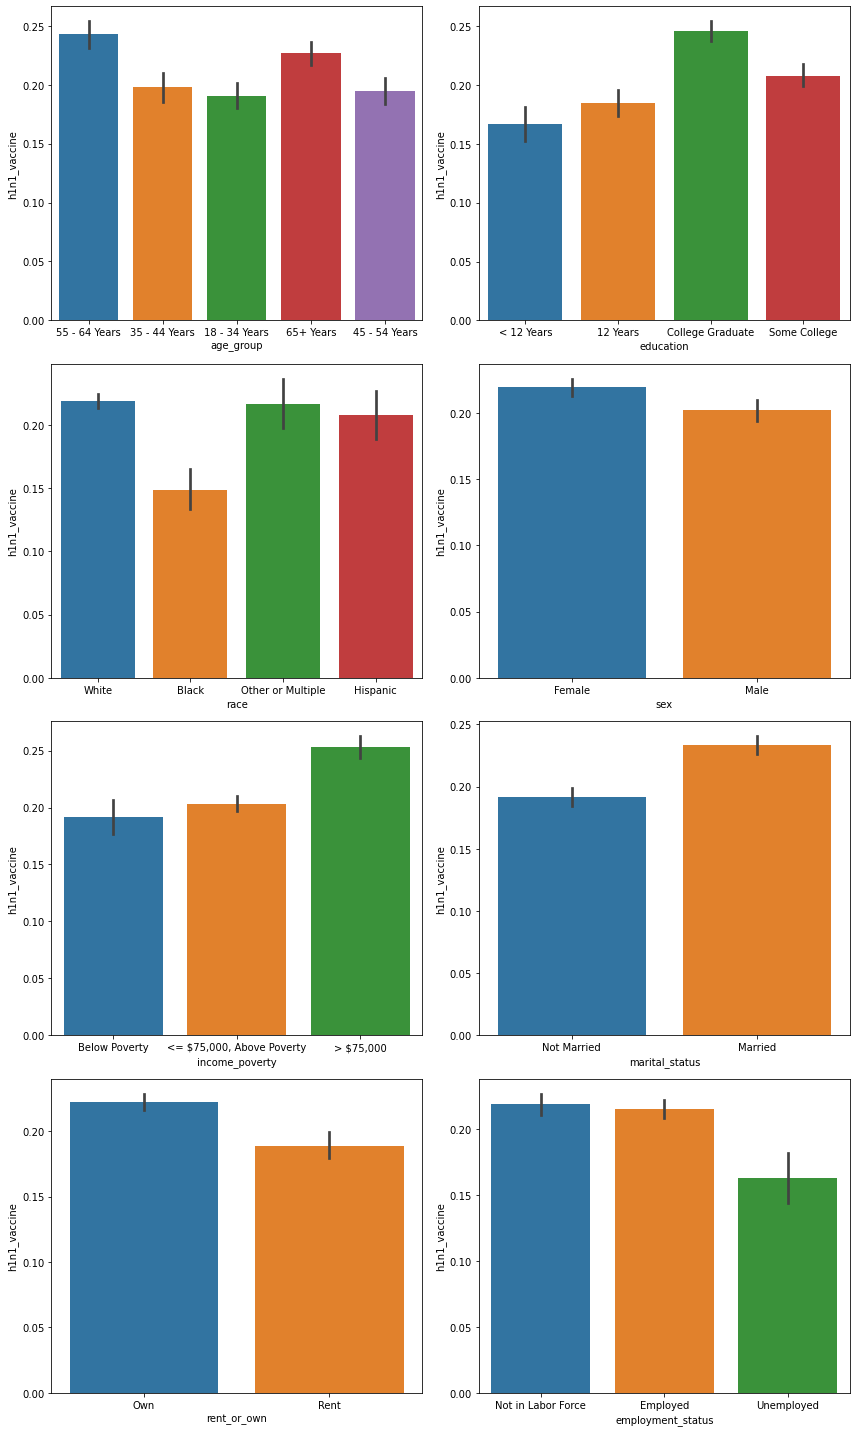

In [155]:
# Plot age group vs. vaccination rate
cat_columns_to_plot = ['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status']

fig, ax = plt.subplots(4, 2, figsize=(12,20))
for row in range(4):
    for column in range(2):
        column_to_plot = cat_columns_to_plot[row*2 + column]
        sns.barplot(data=df_combined,
                    x=df_combined[column_to_plot],
                    y='h1n1_vaccine',
                    ax=ax[row, column]
                    )

fig.tight_layout();

In [156]:
num_cols = df_combined.select_dtypes(np.number).drop('seasonal_vaccine', axis=1)
num_cols.nunique()

respondent_id                  26707
h1n1_concern                       4
h1n1_knowledge                     3
behavioral_antiviral_meds          2
behavioral_avoidance               2
behavioral_face_mask               2
behavioral_wash_hands              2
behavioral_large_gatherings        2
behavioral_outside_home            2
behavioral_touch_face              2
doctor_recc_h1n1                   2
doctor_recc_seasonal               2
chronic_med_condition              2
child_under_6_months               2
health_worker                      2
health_insurance                   2
opinion_h1n1_vacc_effective        5
opinion_h1n1_risk                  5
opinion_h1n1_sick_from_vacc        5
opinion_seas_vacc_effective        5
opinion_seas_risk                  5
opinion_seas_sick_from_vacc        5
household_adults                   4
household_children                 4
h1n1_vaccine                       2
dtype: int64

It looks like most of these are also categorical but there are too many so let's pick some key ones to plot

In [181]:
num_corr = num_cols.corr()['h1n1_vaccine'].sort_values(ascending=False)
num_corr

h1n1_vaccine                   1.000000
doctor_recc_h1n1               0.393890
opinion_h1n1_risk              0.323265
opinion_h1n1_vacc_effective    0.269347
opinion_seas_risk              0.258571
doctor_recc_seasonal           0.209864
opinion_seas_vacc_effective    0.179272
health_worker                  0.169768
h1n1_concern                   0.121929
health_insurance               0.121170
h1n1_knowledge                 0.117951
chronic_med_condition          0.095207
opinion_h1n1_sick_from_vacc    0.075091
behavioral_wash_hands          0.074712
behavioral_touch_face          0.071648
behavioral_face_mask           0.070498
child_under_6_months           0.066962
behavioral_avoidance           0.047690
behavioral_antiviral_meds      0.040608
behavioral_outside_home        0.021768
behavioral_large_gatherings    0.017822
opinion_seas_sick_from_vacc    0.008360
household_adults               0.007545
respondent_id                 -0.003280
household_children            -0.003320


According to [statology](https://www.statology.org/what-is-a-strong-correlation/), no relationship is defined as r < 0.25

So let's investigate any variable with r >= 0.25

In [190]:
key_cols = list(num_corr[abs(num_corr) >= 0.25].drop('h1n1_vaccine').index)
key_cols


['doctor_recc_h1n1',
 'opinion_h1n1_risk',
 'opinion_h1n1_vacc_effective',
 'opinion_seas_risk']

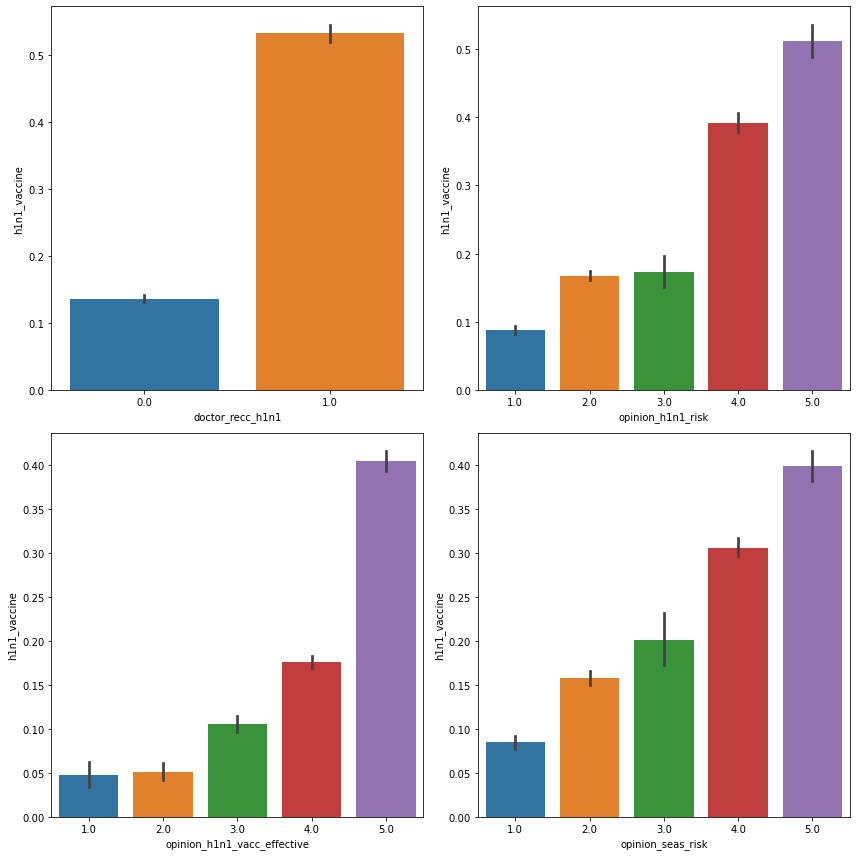

In [192]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
for row in range(2):
    for column in range(2):
        column_to_plot = key_cols[row*2 + column]
        sns.barplot(data=df_combined,
                    x=df_combined[column_to_plot],
                    y='h1n1_vaccine',
                    ax=ax[row, column]
                    )

fig.tight_layout();

## Encoding Features

In [158]:
X_train.income_poverty.value_counts()

<= $75,000, Above Poverty    7214
> $75,000                    3821
Below Poverty                1509
Name: income_poverty, dtype: int64

In [159]:
# Columns that need ordinal encoding
age_group_ord = ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years']
education_ord = ['< 12 Years', '12 Years', 'Some College', 'College Graduate']
income_poverty_ord = ['Below Poverty', '<= $75,000, Above Poverty', '> $75,000']

ord_categories = [age_group_ord, education_ord, income_poverty_ord]

ord_columns = ['age_group', 'education', 'income_poverty']
ohe_columns = X_train.select_dtypes(include=object).drop(columns=ord_columns, axis=1).columns

In [160]:
ord_categories

[['18 - 34 Years',
  '35 - 44 Years',
  '45 - 54 Years',
  '55 - 64 Years',
  '65+ Years'],
 ['< 12 Years', '12 Years', 'Some College', 'College Graduate'],
 ['Below Poverty', '<= $75,000, Above Poverty', '> $75,000']]

In [161]:
ohe_columns

Index(['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'employment_industry',
       'employment_occupation'],
      dtype='object')

In [162]:
subpipe_numerics = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler())
])

subpipe_ohe = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

subpipe_ord = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OrdinalEncoder())
])

In [163]:
CT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_ohe, ohe_columns),
    ('subpipe_ord', subpipe_ord, ord_columns)
], remainder='passthrough')

## Model Saving

In [722]:
class ModelStorer():
    def __init__(self):
        self.models = {}
        self.model_scores = pd.DataFrame(columns=['model', 'dataset', 'metric', 'value'])

    def add_model(self, model):
        self.models[model.model_name] = model
        self.model_scores = self.model_scores.append(model.model_scores)

    def plot_models_roc_curves(self):
        fig, ax = plt.subplots(figsize=(6,6))
        for name, model in self.models.items():
            model.plot_model_roc_curve(ax)
        plt.show()

    def plot_models_scores(self):
        data = self.model_scores
        g = sns.FacetGrid(data[data['dataset']=='test'], col="metric", col_wrap=2, height=4)
        g.map(sns.barplot, "value", "model", order=list(self.models.keys()))

    def plot_models_confusion_matricies(self):
        num_models = len(self.models.keys())

        nrows = 2
        ncols = math.ceil(num_models/nrows)

        fig, axes = plt.subplots(
                        nrows=nrows,
                        ncols=ncols,
                        figsize=(ncols*3, nrows*3)
        )
        fig.suptitle("Confusion Matrix Comparison")

        # Turn off all the axes in case there is nothing to plot
        [ax.axis('off') for ax in axes.ravel()]


        for i, (name, model) in enumerate(self.models.items()):
            # Logic for making rows and columns for matrices
            row = i // ncols
            col = i % ncols
            ax = axes[row, col]
            ax.set_title(name)
            ax.set_axis_on() # turn back on the axis
            model.plot_model_confusion_matrix(ax)

        plt.tight_layout()


In [723]:
model_dict = ModelStorer()

In [596]:
class SaveModel():
    def __init__(self, model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, model_name='None'):
            self.model = model
            self.model_name = model_name
            self.X_train = X_train
            self.X_test = X_test
            self.y_train = y_train
            self.y_test = y_test
            self.score_model()

    def info(self):
         print(f'-------{self.model_name} Information-------')
         print(f'Model: {self.model}')
         
    def score_model(self):
          ytrain_hat = self.model.predict(X_train)
          ytest_hat = self.model.predict(X_test)
          self.model_scores = pd.DataFrame([
                         [self.model_name, 'train', 'accuracy_score', accuracy_score(y_train, ytrain_hat)],
                         [self.model_name, 'train', 'recall_score', recall_score(y_train, ytrain_hat)],
                         [self.model_name, 'train', 'precision_score', precision_score(y_train, ytrain_hat)],
                         [self.model_name, 'train', 'f1_score', f1_score(y_train, ytrain_hat)],
                         [self.model_name, 'test', 'accuracy_score', accuracy_score(y_test, ytest_hat)],
                         [self.model_name, 'test', 'recall_score', recall_score(y_test, ytest_hat)],
                         [self.model_name, 'test', 'precision_score', precision_score(y_test, ytest_hat)],
                         [self.model_name, 'test', 'f1_score', f1_score(y_test, ytest_hat)]
                         ],
                         columns=['model', 'dataset', 'metric', 'value'])

    def plot_model_scores(self, ax):
        """ 
        Inputs:
        - model: the model you want to score
        - X_train, X_test, y_train, y_test: the outpus of your train test split
        - model_name: the name of the model for graphing purposes

        Overview
        This function takes in a model and data and plots scores to compare
        train and test scoring

        Requires:
        - Seaborn (sns)
        - Matplotlib.pyplot (plt)
        - pandas (pd)
        """
        plot_data = self.model_scores

        sns.barplot(data=plot_data,
                    x='metric',
                    y='value',
                    hue='dataset',
                    ax=ax
                    )
        ax.set_title(f'{self.model_name} Test vs. Train Scores')

    def plot_model_roc_curve(self, ax):
        plot_roc_curve(self.model, self.X_test,self.y_test, ax=ax, name=self.model_name)

    def plot_model_confusion_matrix(self, ax):
        cm_display = plot_confusion_matrix(self.model, 
                                           self.X_test,
                                           self.y_test, 
                                           normalize='true', 
                                           cmap='plasma',
                                           ax=ax)
        cm_display.im_.set_clim(0, 1)
    

## Baseline Models

Let's start off by creating some baseline models

In [682]:
dum_model = DummyClassifier(strategy='most_frequent')
lr_model = LogisticRegression()
tree_model = DecisionTreeClassifier()
model_list = [('dummy',dum_model), ('logreg',lr_model), ('dtc',tree_model)]

dummy_models = {}

for name, model in model_list:
    loop_model_pipe = ImPipeline(steps=[
        ('ct', CT),
        ('sm',SMOTE(random_state=42)),
        (name, model)
    ])

    loop_model_pipe.fit(X_train,y_train)

    dummy_models[name] = loop_model_pipe
    

/Users/willbennett/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [724]:
for name, model in dummy_models.items():
    loop_model_results = SaveModel(
        model=model,
        model_name=name,
        )

    model_dict.add_model(loop_model_results)

/Users/willbennett/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [725]:
model_dict.models

{'dummy': <__main__.SaveModel at 0x7ff515bb7430>,
 'logreg': <__main__.SaveModel at 0x7ff5163ab280>,
 'dtc': <__main__.SaveModel at 0x7ff515bb7d60>}

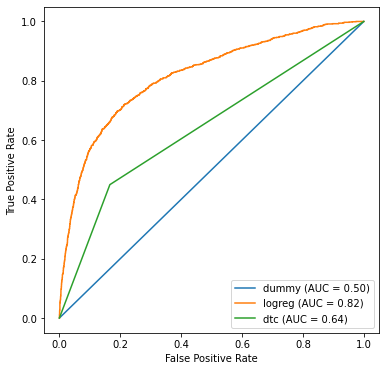

In [726]:
model_dict.plot_models_roc_curves()

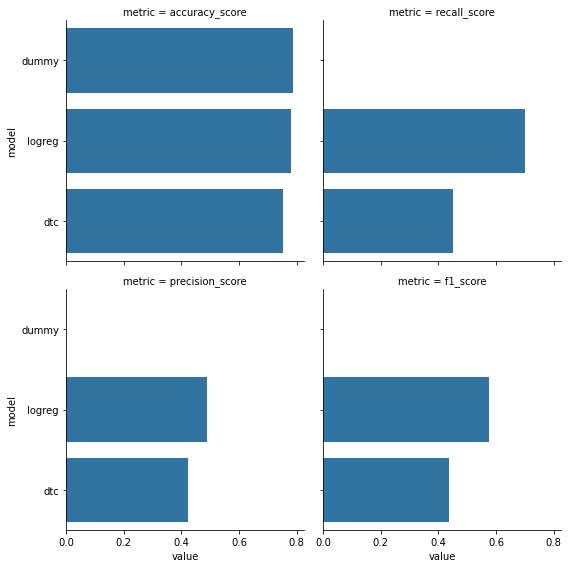

In [727]:
model_dict.plot_models_scores()
    

Ok! Here we have 3 baseline models, a dummy, logreg, and decision tree. 

Both dtc and logreg are doing better than the dummy which is great.

We're seeing some errors which we'll have to fix while optimizing

## Decision Tree Classifier Optimization

### Hyperparameter Tuning

We can use gridsearch to find the best hyperparameters

In [606]:
parameters = {'dtc__criterion': ['gini', 'entropy'],
          'dtc__min_samples_leaf': [1, 40, 80],
          'sm__k_neighbors': [1, 10, 20]}

gs = GridSearchCV(estimator=model_dict.models['dtc'].model,
                        param_grid=parameters,
                        scoring='roc_auc',
                        n_jobs=-1)

gs.fit(X_train, y_train)


GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7ff5144a5880>),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_imput

In [637]:
gs.best_params_

{'dtc__criterion': 'entropy',
 'dtc__min_samples_leaf': 80,
 'sm__k_neighbors': 20}

In [728]:
dtc_optimized_results = SaveModel(
    model=gs.best_estimator_,
    model_name = 'DTC Optimized',
)

model_dict.add_model(dtc_optimized_results)

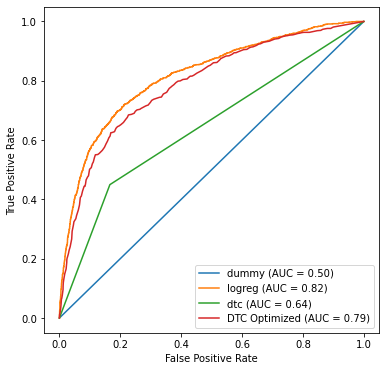

In [729]:
model_dict.plot_models_roc_curves()

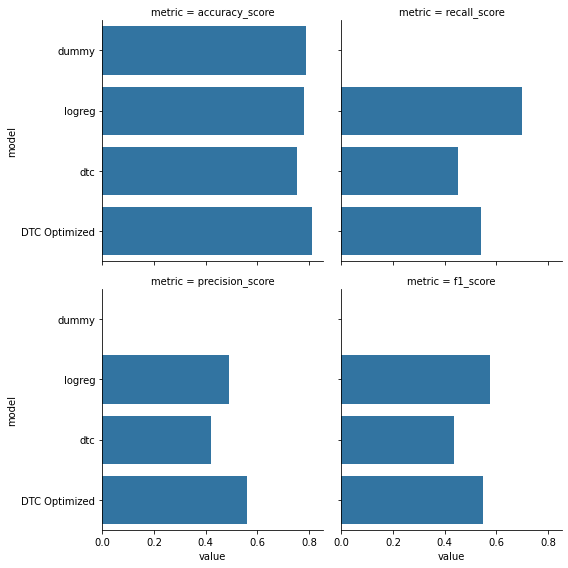

In [730]:
model_dict.plot_models_scores()

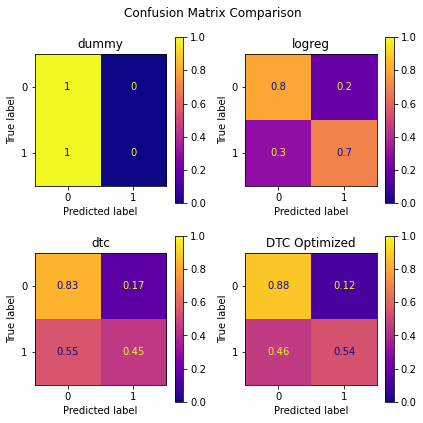

In [731]:
model_dict.plot_models_confusion_matricies()

Our accuracy is looking pretty good here, let's see if Logistic Regresssion can do better

## Logistic Regression Optimization

## Hyperparameter Tuning

We can use gridsearch to improve our logistic regression model

In [636]:
# Create the search space for gridsearch
space = dict()
space['logreg__penalty'] = ['none', 'l1', 'l2']
space['logreg__C'] = [1e-7, 1e-6, 1e-5]
space['logreg__max_iter'] = [100, 500, 1000]
space['sm__k_neighbors'] = [1, 5, 9]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

gs_lr = GridSearchCV(estimator=model_dict.models['logreg'].model,
                        param_grid=space,
                        cv=cv,
                        verbose=1,
                        scoring='roc_auc',
                        n_jobs=-1
                    )


gs_lr.fit(X_train, y_train)

Fitting 30 folds for each of 81 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 35.6min finished
/Users/willbennett/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/willbennett/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale th

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7ff5144a58...
                                                                                          SimpleImputer(str

In [696]:
gs_lr.best_params_

{'logreg__C': 1e-07,
 'logreg__max_iter': 100,
 'logreg__penalty': 'none',
 'sm__k_neighbors': 5}

In [732]:
lr_optimized_results = SaveModel(
    model=gs_lr.best_estimator_,
    model_name = 'LR Optimized',
)

model_dict.add_model(lr_optimized_results)

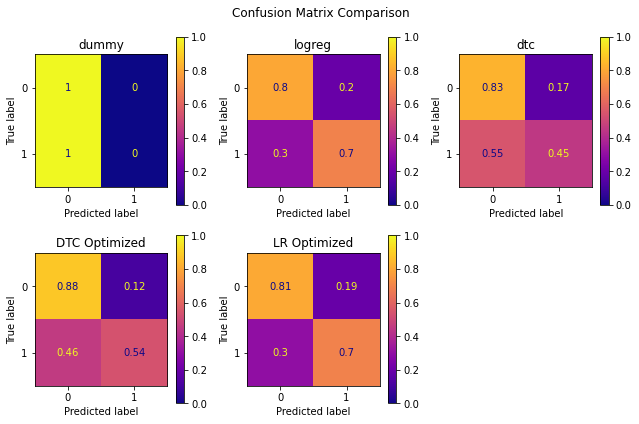

In [733]:
model_dict.plot_models_confusion_matricies()

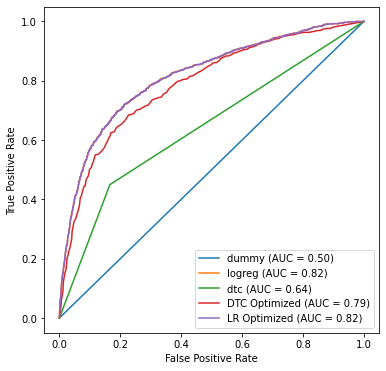

In [734]:
model_dict.plot_models_roc_curves()

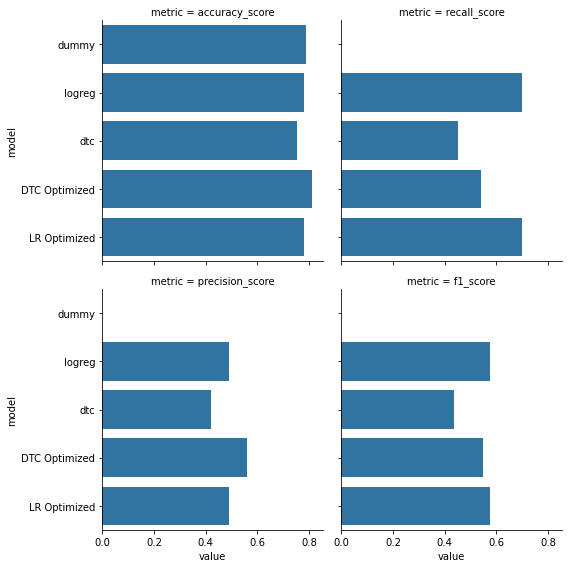

In [735]:
model_dict.plot_models_scores()

It doesn't look like the model is overfitting but it didn't improve either

## SelectFromModel

In [643]:
lr_model2 = LogisticRegression(max_iter=1000)

In [645]:
lr_pipe2 = ImPipeline(steps=[
        ('ct', CT),
        ('sm',SMOTE(random_state=42)),
        ('sfm',SelectFromModel(lr_model2)),
        ('logreg',lr_model2)
    ])

In [646]:
lr_pipe2.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff5144a5880>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent'))...
       'hhs_geo_region', 'census_msa', 'employment_industry',
       'employment_occupation'],
      dtype='object'

In [736]:
lr_selectfrommodel_results = SaveModel(
    model=lr_pipe2,
    model_name = 'LR SelectFromModel',
)

model_dict.add_model(lr_selectfrommodel_results)

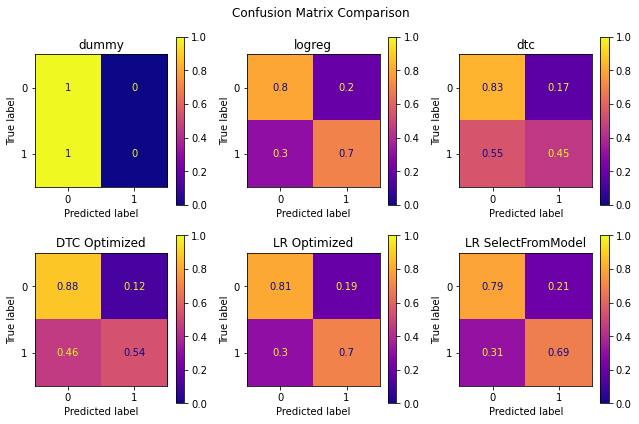

In [737]:
model_dict.plot_models_confusion_matricies()

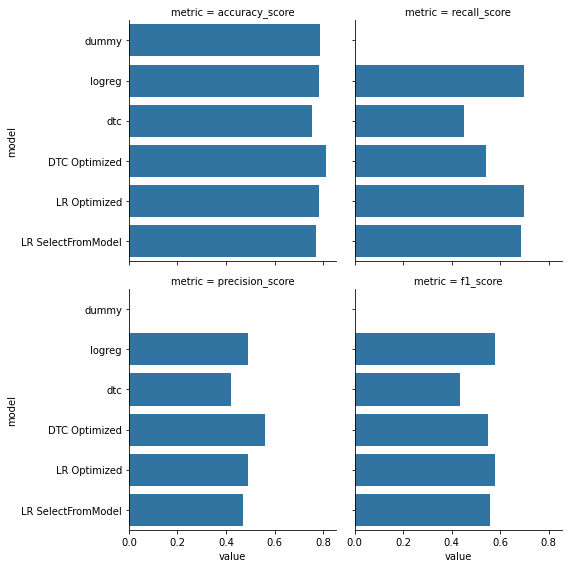

In [738]:
model_dict.plot_models_scores()

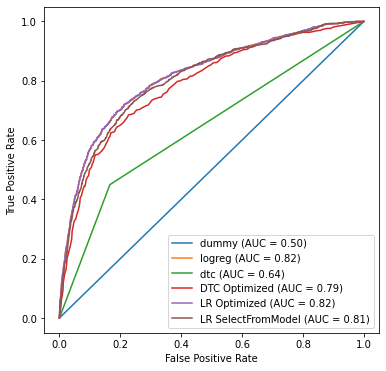

In [739]:
model_dict.plot_models_roc_curves()

## Manual Feature Selection

In [669]:
def grab_keycols(df):
    return df[key_cols]

In [670]:
GrabKeyCols = FunctionTransformer(grab_keycols)

In [671]:
CT2 = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics, selector(dtype_include=np.number)),
], remainder='passthrough')

In [677]:
lr_pipe_manual = ImPipeline(steps=[
        ('num',GrabKeyCols),
        ('ct', CT2),
        ('sm',SMOTE(random_state=42)),
        ('lr',lr_model)
    ])

In [678]:
lr_pipe_manual.fit(X_train,y_train)

Pipeline(steps=[('num',
                 FunctionTransformer(func=<function grab_keycols at 0x7ff53112edc0>)),
                ('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff52c62e670>)])),
                ('sm', SMOTE(random_state=42)), ('lr', LogisticRegression())])

In [740]:
lr_manualfeatures_results = SaveModel(
    model=lr_pipe_manual,
    model_name = 'LR Manual Features',
)

model_dict.add_model(lr_manualfeatures_results)

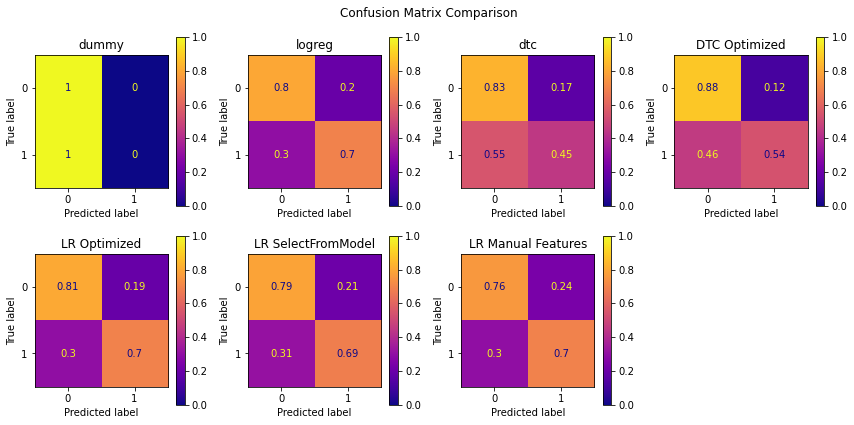

In [741]:
model_dict.plot_models_confusion_matricies()

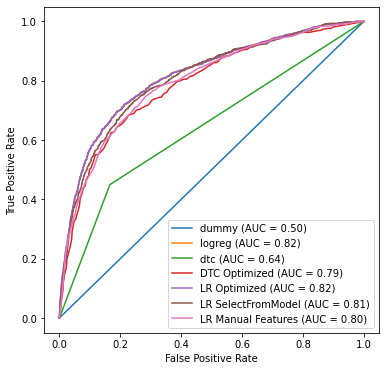

In [742]:
model_dict.plot_models_roc_curves()

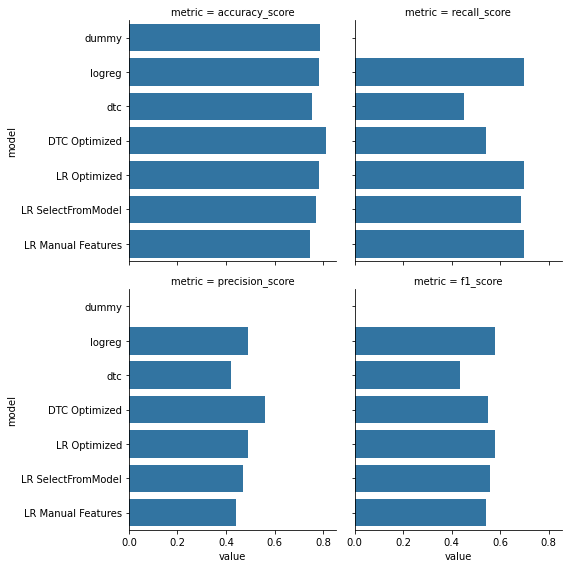

In [743]:
model_dict.plot_models_scores()